Importing relevant packages and libraries

In [29]:
# Customer Lifetime Value (CLV) Prediction Project

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [17]:
df = pd.read_csv('/content/customer_segmentation.csv', encoding='latin-1')
# or encoding='ISO-8859-1' if 'latin-1' doesn't work

In [18]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [19]:
# 3. Data Cleaning
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


<ipython-input-19-050de41494ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-input-19-050de41494ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [21]:
# 4. Feature Engineering
# RFM (Recency, Frequency, Monetary)
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]


In [22]:
# Add Customer Age (in months)
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min()
rfm['CustomerAge'] = (latest_date - first_purchase).dt.days // 30


In [23]:
# 5. CLV Calculation (Baseline Model)
# Simplified CLV = (Avg Order Value) * (Purchase Frequency) * (Customer Age in Months)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
rfm['CLV'] = rfm['AOV'] * rfm['Frequency'] * rfm['CustomerAge']


In [24]:
# 6. Model Building
features = ['Recency', 'Frequency', 'Monetary', 'CustomerAge']
X = rfm[features]
y = rfm['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [25]:
# 7. Model Evaluation
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.9730284214808815
RMSE: 1326.6535360637076


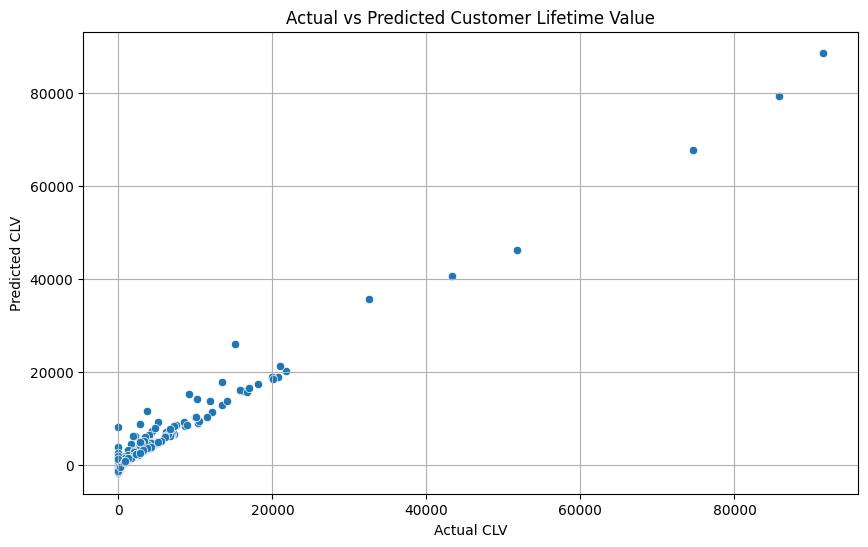

In [26]:
# 8. Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.grid(True)
plt.show()

In [27]:
# 9. Save Results
rfm['Predicted_CLV'] = model.predict(rfm[features])
rfm.reset_index().to_csv('predicted_clv_output.csv', index=False)

In [28]:
# 10. Conclusion
print("\nConclusion:")
print("- Model built using linear regression shows basic predictive power for CLV.")
print("- Can be improved using XGBoost, customer segmentation, or time-series forecasting.")
print("- Business can use top CLV customers for targeted marketing or loyalty programs.")



Conclusion:
- Model built using linear regression shows basic predictive power for CLV.
- Can be improved using XGBoost, customer segmentation, or time-series forecasting.
- Business can use top CLV customers for targeted marketing or loyalty programs.


In [30]:
# 11. Model Building with XGBoost
features = ['Recency', 'Frequency', 'Monetary', 'CustomerAge']
X = rfm[features]
y = rfm['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# 12. Model Evaluation
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R2 Score: 0.957128257247267
RMSE: 1672.5915785016887


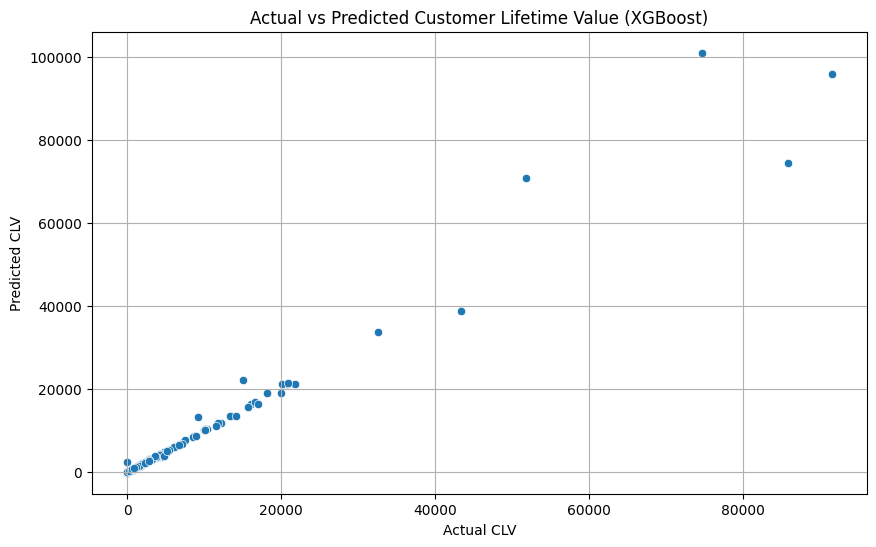

In [32]:
# 8. Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted Customer Lifetime Value (XGBoost)")
plt.grid(True)
plt.show()


In [33]:
# 9. Save Results
rfm['Predicted_CLV'] = model.predict(rfm[features])
rfm.reset_index().to_csv('predicted_clv_output.csv', index=False)


In [34]:
# 10. Conclusion
print("\nConclusion:")
print("- XGBoost regression improves prediction accuracy over linear model.")
print("- Stronger handling of non-linear relationships and feature interactions.")
print("- Enables more reliable segmentation of high-value customers for strategic decision-making.")



Conclusion:
- XGBoost regression improves prediction accuracy over linear model.
- Stronger handling of non-linear relationships and feature interactions.
- Enables more reliable segmentation of high-value customers for strategic decision-making.
